In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<a href="javascript:code_toggle()">
<button>Toggle Code</button></a>''')

Not showing the code to save space... This is simply just changing the nx and ny variables in the original code to 512, and setting $\alpha = 10^{-3}$ and $\beta = 10^{-2}$.

In [2]:
from __future__ import print_function, division, absolute_import

import math

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import scipy.io as sio

import dolfin as dl

from hippylib import nb

import logging

logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)

In [3]:
class Image(dl.Expression):
    def __init__(self, Lx, Ly, data, **kwargs):
        self.data = data
        self.hx = Lx/float(data.shape[1]-1)
        self.hy = Ly/float(data.shape[0]-1)
        
    def eval(self, values, x):
        j = int(math.floor(x[0]/self.hx))
        i = int(math.floor(x[1]/self.hy))
        values[0] = self.data[i,j]

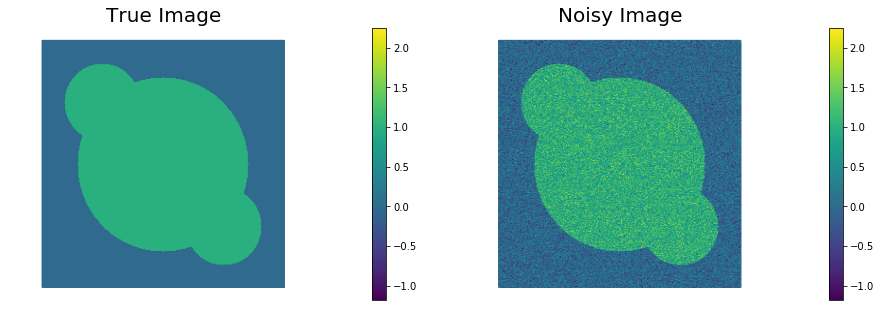

In [4]:
data = sio.loadmat('circles.mat')['im']

Lx = float(data.shape[1])/float(data.shape[0])
Ly = 1.

nx, ny = [512, 512]
  
mesh = dl.RectangleMesh(dl.Point(0,0),dl.Point(Lx,Ly),nx, ny)
Vm = dl.FunctionSpace(mesh, "Lagrange",1)
Vw = dl.VectorFunctionSpace(mesh, "DG",0)
Vwnorm = dl.FunctionSpace(mesh, "DG",0)

trueImage = Image(Lx,Ly,data,degree = 1)
m_true  = dl.interpolate(trueImage, Vm)

np.random.seed(seed=1)
noise_std_dev = .3
noise = noise_std_dev*np.random.randn(data.shape[0], data.shape[1])
noisyImage = Image(Lx,Ly,data+noise, degree = 1)
d = dl.interpolate(noisyImage, Vm)

# Get min/max of noisy image, so that we can show all plots in the same scale
vmin = np.min(d.vector().get_local())
vmax = np.max(d.vector().get_local())

plt.figure(figsize=(15,5))
nb.plot(m_true, subplot_loc=121, mytitle="True Image", vmin=vmin, vmax = vmax)
nb.plot(d, subplot_loc=122, mytitle="Noisy Image", vmin=vmin, vmax = vmax)
plt.show()

In [5]:
class PDTVDenoising:
    def __init__(self, Vm, Vw, Vwnorm, d, alpha, beta):
        self.alpha   = dl.Constant(alpha)
        self.beta    = dl.Constant(beta)
        self.d       = d
        self.m_tilde  = dl.TestFunction(Vm)
        self.m_hat = dl.TrialFunction(Vm)
        
        self.Vm = Vm
        self.Vw = Vw
        self.Vwnorm = Vwnorm
        
    def cost_reg(self, m):
        return dl.sqrt( dl.inner(dl.grad(m), dl.grad(m)) + self.beta)*dl.dx
    
    def cost_misfit(self, m):
        return dl.Constant(.5)*dl.inner(m-self.d, m - self.d)*dl.dx
        
    def cost(self, m):        
        return self.cost_misfit(m) + self.alpha*self.cost_reg(m)
        
    def grad_m(self, m):    
        grad_ls = dl.inner(self.m_tilde, m - self.d)*dl.dx        
        TVm = dl.sqrt( dl.inner(dl.grad(m), dl.grad(m)) + self.beta)
        grad_tv = dl.Constant(1.)/TVm*dl.inner(dl.grad(m), dl.grad(self.m_tilde))*dl.dx
        
        grad = grad_ls + self.alpha*grad_tv
        
        return grad
        
    def Hessian(self,m, w):
        H_ls = dl.inner(self.m_tilde, self.m_hat)*dl.dx
        
        TVm = dl.sqrt( dl.inner(dl.grad(m), dl.grad(m)) + self.beta)
        A = dl.Constant(1.)/TVm * (dl.Identity(2) 
                                   - dl.Constant(.5)*dl.outer(w, dl.grad(m)/TVm )
                                   - dl.Constant(.5)*dl.outer(dl.grad(m)/TVm, w ) )
        
        H_tv = dl.inner(A*dl.grad(self.m_tilde), dl.grad(self.m_hat))*dl.dx
         
        H = H_ls + self.alpha*H_tv
                                   
        return H
    
    def compute_w_hat(self, m, w, m_hat):
        TVm = dl.sqrt( dl.inner(dl.grad(m), dl.grad(m)) + self.beta)
        A = dl.Constant(1.)/TVm * (dl.Identity(2) 
                                   - dl.Constant(.5)*dl.outer(w, dl.grad(m)/TVm )
                                   - dl.Constant(.5)*dl.outer(dl.grad(m)/TVm, w ) )
        
        expression = A*dl.grad(m_hat) - w + dl.grad(m)/TVm
        
        return dl.project(expression, self.Vw)
    
    def wnorm(self, w):
        return dl.inner(w,w)

In [6]:
def PDNewton(pdProblem, m, w, parameters):
    
    termination_reasons = [
                           "Maximum number of Iteration reached",      #0
                           "Norm of the gradient less than tolerance", #1
                           "Maximum number of backtracking reached",   #2
                           "Norm of (g, m_hat) less than tolerance"       #3
                           ]
    
    rtol          = parameters["rel_tolerance"]
    atol          = parameters["abs_tolerance"]
    gdm_tol       = parameters["gdm_tolerance"]
    max_iter      = parameters["max_iter"]
    c_armijo      = parameters["c_armijo"] 
    max_backtrack = parameters["max_backtracking_iter"]
    prt_level     = parameters["print_level"]
    cg_coarse_tol = parameters["cg_coarse_tolerance"]
        
    Jn = dl.assemble( pdProblem.cost(m)   )
    gn = dl.assemble( pdProblem.grad_m(m) )
    g0_norm = gn.norm("l2")
    gn_norm = g0_norm
    tol = max(g0_norm*rtol, atol)
    
    m_hat = dl.Function(pdProblem.Vm)
    w_hat = dl.Function(pdProblem.Vw)
        
    converged = False
    reason = 0
    total_cg_iter = 0
        
    if prt_level > 0:
        print( "{0:>3} {1:>15} {2:>15} {3:>15} {4:>15} {5:>15} {6:>7}".format(
                "It", "cost", "||g||", "(g,m_hat)", "alpha_m", "tol_cg", "cg_it") )
        
    for it in range(max_iter):
        
        # Compute m_hat
        Hn = dl.assemble( pdProblem.Hessian(m,w) )
        solver = dl.PETScKrylovSolver("cg", "petsc_amg")
        solver.set_operator(Hn)
        solver.parameters["nonzero_initial_guess"] = False
        cg_tol = min(cg_coarse_tol, math.sqrt( gn_norm/g0_norm) )
        solver.parameters["relative_tolerance"] = cg_tol
        lin_it = solver.solve(m_hat.vector(),-gn)   
        total_cg_iter += lin_it
        
        # Compute w_hat
        w_hat = pdProblem.compute_w_hat(m, w, m_hat)
            
        ### Line search for m
        mhat_gn = m_hat.vector().inner(gn)
            
        if(-mhat_gn < gdm_tol):
            self.converged=True
            self.reason = 3
            break
        
        alpha_m = 1.   
        bk_converged = False 
        for j in range(max_backtrack):
            Jnext = dl.assemble( pdProblem.cost(m + dl.Constant(alpha_m)*m_hat) )
            if Jnext < Jn + alpha_m*c_armijo*mhat_gn:
                Jn = Jnext
                bk_converged = True
                break
                
            alpha_m = alpha_m/2.
                
        if not bk_converged:
            self.reason = 2
            break
            
        ### Line search for w
        alpha_w = 1
        bk_converged = False
        for j in range(max_backtrack):
            norm_w = dl.project(pdProblem.wnorm(w + dl.Constant(alpha_w)*w_hat), pdProblem.Vwnorm)
            if norm_w.vector().norm("linf") <= 1:
                bk_converged = True
                break
            alpha_w = alpha_w/2.
        
        
        ### Update
        m.vector().axpy(alpha_m, m_hat.vector())
        w.vector().axpy(alpha_w, w_hat.vector())
        
        gn = dl.assemble( pdProblem.grad_m(m) )
        gn_norm = gn.norm("l2")
            
        if prt_level > 0:
            print( "{0:3d} {1:15e} {2:15e} {3:15e} {4:15e} {5:15e} {6:7d}".format(
                    it, Jn, gn_norm, mhat_gn, alpha_m, cg_tol, lin_it) )
                
        if gn_norm < tol:
            converged = True
            reason = 1
            break
            
    final_grad_norm = gn_norm
        
    if prt_level > -1:
        print( termination_reasons[reason] )
        if converged:
            print( "Inexact Newton CG converged in ", it, \
                "nonlinear iterations and ", total_cg_iter, "linear iterations." )
        else:
            print( "Inexact Newton CG did NOT converge after ", self.it, \
                "nonlinear iterations and ", total_cg_iter, "linear iterations.")
        print ("Final norm of the gradient", final_grad_norm)
        print ("Value of the cost functional", Jn)
            
    return m, w

 It            cost           ||g||       (g,m_hat)         alpha_m          tol_cg   cg_it
  0    8.260748e-02    7.478885e-04   -3.484335e-01    1.000000e+00    5.000000e-01       1
  1    3.858014e-02    5.343510e-04   -8.201775e-02    1.000000e+00    5.000000e-01       1
  2    3.529863e-02    4.490560e-04   -5.900333e-03    1.000000e+00    5.000000e-01       1
  3    3.481471e-02    3.025374e-04   -7.166163e-04    1.000000e+00    5.000000e-01       1
  4    3.466944e-02    2.018551e-04   -1.758879e-04    1.000000e+00    4.626002e-01       1
  5    3.461762e-02    1.323255e-04   -6.063050e-05    1.000000e+00    3.778646e-01       1
  6    3.459254e-02    9.850139e-05   -2.917246e-05    1.000000e+00    3.059413e-01       2
  7    3.457665e-02    7.095766e-05   -1.874617e-05    1.000000e+00    2.639596e-01       2
  8    3.456679e-02    5.056672e-05   -1.199533e-05    1.000000e+00    2.240350e-01       2
  9    3.456113e-02    3.133892e-05   -7.302405e-06    1.000000e+00    1.891249e

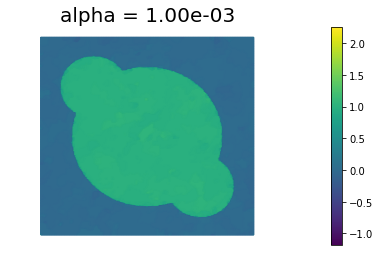

In [7]:
alpha = 1e-3
beta  = 1e-2
pdProblem = PDTVDenoising(Vm, Vw, Vwnorm, d, alpha, beta)

parameters = {}
parameters["rel_tolerance"]         = 1e-6
parameters["abs_tolerance"]         = 1e-9
parameters["gdm_tolerance"]         = 1e-18
parameters["max_iter"]              = 100
parameters["c_armijo"]              = 1e-5
parameters["max_backtracking_iter"] = 10
parameters["print_level"]           = 1
parameters["cg_coarse_tolerance"]   = 0.5

m0 = dl.Function(Vm)
w0 = dl.Function(Vw)

m, w = PDNewton(pdProblem, m0, w0, parameters)

plt.figure()
nb.plot(m, vmin=vmin, vmax = vmax, mytitle="alpha = {0:1.2e}".format(alpha))
plt.show()

With increasing resolution, the number of nonlinear iterations remains relatively the same (increase from 16 --> 16 --> 18 iterations). However, the number of linear iterations increase significantly (increase from 39 --> 60 --> 84 iterations). 